# Intestinal transit model

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')

# Set default grid style for plots
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["font.size"] = 14

sample_list = ['L1', 'L2', 'L3', 'H1', 'H2', 'H3']

## Model1 (Zero-order model)

In [74]:
# Zero-order model: Indirect estimation of t_in
def model1(w, t, q):
    t_tot, alpha, k_e, A = w
    t_in = q / alpha
    c = np.zeros(len(t))
    
    cond1 = (t_tot < t) & (t <= t_in + t_tot)
    cond2 = (t > t_in + t_tot)
    
    c[cond1] = 1 - np.exp(-k_e * (t[cond1] - t_tot))
    c[cond2] = np.exp(-k_e * (t[cond2] - t_tot - t_in)) - np.exp(-k_e * (t[cond2] - t_tot))
    
    return (alpha / (A * k_e)) * c

# Derivative function
def model1_dev(w, t, q):
    t_tot, alpha, k_e, A = w
    t_in = q / alpha
    d = np.zeros(len(t))
    
    cond1 = (t_tot < t) & (t <= t_in + t_tot)
    cond2 = (t > t_in + t_tot)
    
    d[cond1] = k_e * np.exp(-k_e * (t[cond1] - t_tot))
    d[cond2] = -k_e * (np.exp(-k_e * (t[cond2] - t_tot - t_in)) - np.exp(-k_e * (t[cond2] - t_tot)))
    
    return (alpha / (A * k_e)) * d

# Loss function
def model1_loss(w, t, y_true, q, l):
    y_pred = model1(w, t, q)
    dev = model1_dev(w, (t[:-1] + t[1:]) / 2, q)
    
    err = np.sum(((np.diff(y_true) / np.diff(t)) - dev) ** 2)
    loss = l * np.linalg.norm(y_pred - y_true, ord=2) ** 2 + (1 - l) * err
    return loss


for n in range(6):
    df = pd.read_csv(f'VCM_{sample_list[n]}.csv', header=0, index_col=0)
    time = np.array(df.columns, dtype=float)
    data = np.array(df)
    avg = data.mean(axis=0)
    std = data.std(axis=0)
    
    # Dose level
    q = 0.5 if n < 3 else 10  # Low-dose for first 3 samples, high-dose for the rest
    
    # Use data up to 4 days after administration
    mask = time <= 96
    t, y = time[mask], avg[mask]
    
    # Optimization
    l = 0.9  # Penalty coefficient
    res = basinhopping(
        model1_loss, x0=[1, 1, 1, 1], stepsize=0.05,
        minimizer_kwargs={"method": 'Nelder-Mead', "args": (t, y, q, l)},
        niter=1000, niter_success=100, seed=0
    )
    
    t_tot, alpha, k_e, A = res.x
    t_in = q / alpha
    print([t_tot, t_in, k_e, A])
    pd.DataFrame([[t_tot, t_in, k_e, A]],columns=['t_tot', 't_in', 'k_e', 'A']).to_csv(f'model1_{sample_list[n]}.csv')


[4.170077503978667, 4.177245176757478, 0.3511320715193563, 0.24434138286169454]
[4.963228593118433, 7.036771412733361, 0.5656130043968707, 0.3262657869483302]
[3.165014318018187, 7.810328079974033, 0.6612117430569568, 0.17417216863335017]
[11.82073153463976, 22.913528032573115, 0.16807560368712857, 0.14655463756217724]
[4.049506987737679, 24.65690603408184, 0.16169230194747697, 0.21964990164675102]
[4.272734547919847, 7.1417892616908505, 0.575148368977226, 0.7359168907541417]


Mouse L1 RMSE: 0.0038
Mouse L2 RMSE: 0.0046
Mouse L3 RMSE: 0.0055
Mouse H1 RMSE: 0.5316
Mouse H2 RMSE: 0.1662
Mouse H3 RMSE: 0.0319
Overall RMSE: 0.2107


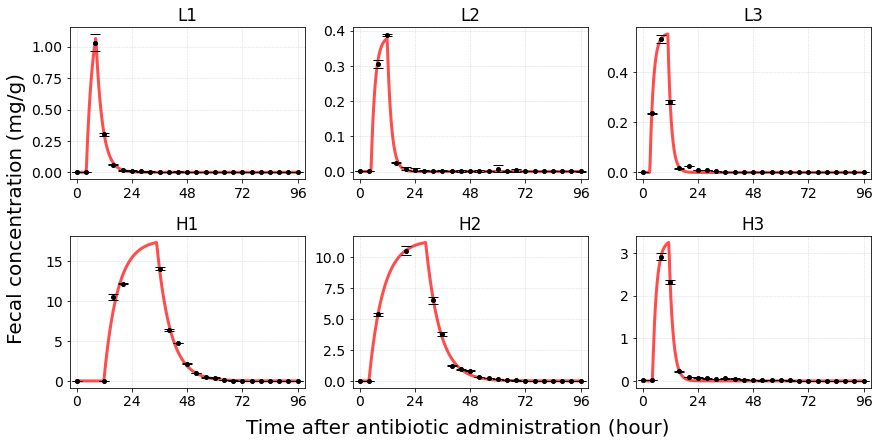

In [78]:
# Store RMSE values for each sample
rmse_list = []
all_y_true = []
all_y_pred = []

# Plotting results
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for n, ax in enumerate(axes.flatten()):
    df = pd.read_csv(f'VCM_{sample_list[n]}.csv', header=0, index_col=0)
    para_df = pd.read_csv(f'model1_{sample_list[n]}.csv', header=0, index_col=0)
    time = np.array(df.columns, dtype=float)
    data = np.array(df)
    avg = data.mean(axis=0)
    std = data.std(axis=0)
    
    # Dose level
    q = 0.5 if n < 3 else 10  # Low-dose for first 3 samples, high-dose for the rest
    
    # Use data up to 4 days after administration
    mask = time <= 96
    t, y = time[mask], avg[mask]
    
    t_tot, t_in, k_e, A = para_df.iloc[0,:]
    alpha = q / t_in
    
    # Plot fitting results
    t_fit = np.linspace(min(t), max(t), 500)
    y_fit = model1([t_tot, alpha, k_e, A], t_fit, q)
    y_pred = model1([t_tot, alpha, k_e, A], t, q)
    
    ax.plot(t_fit, y_fit, color="red", lw=3, alpha=0.7)
    ax.errorbar(t, y, yerr=std[mask], marker='o', markersize=4, color='black', capthick=1, capsize=5, lw=0)
    ax.set_title(f"{sample_list[n]}")
    ax.set_xlim(-3, 99)
    ax.set_xticks(np.arange(0, 97, 24))
    # Compute RMSE for this sample
    rmse = mean_squared_error(y, y_pred, squared=False)
    rmse_list.append(rmse)
    
    # Store values for overall RMSE computation
    all_y_true.extend(y)
    all_y_pred.extend(y_pred)
    
    print(f"Mouse {sample_list[n]} RMSE: {rmse:.4f}")

# Compute overall RMSE
overall_rmse = mean_squared_error(all_y_true, all_y_pred, squared=False)
print(f"Overall RMSE: {overall_rmse:.4f}")
    
# Labels and layout
fig.text(0.5, -0.01, 'Time after antibiotic administration (hour)', ha='center', va='center', fontsize=20)
fig.text(-0.01, 0.5, 'Fecal concentration (mg/g)', ha='center', va='center', rotation='vertical', fontsize=20)
fig.tight_layout()
plt.show()


## Model2 (First-order model)

In [79]:
# First-order model
def model2(w, t, q):
    t_tot, k_a, k_b, A = w
    cond = (t >= t_tot)
    c = np.zeros(len(t))
    c[cond] = (np.exp(-k_a*(t[cond] - t_tot))-np.exp(-k_b*(t[cond] - t_tot)))
    return k_a * q / (A * (k_b - k_a)) * c

# Derivative function
def model2_dev(w, t, q):
    t_tot, k_a, k_b, A = w
    cond = (t >= t_tot)
    d = np.zeros(len(t))
    d[cond] = -k_a * np.exp(-k_a * (t[cond] - t_tot)) + k_b * np.exp(-k_b * (t[cond] - t_tot))
    return k_a * q / (A * (k_b - k_a)) * d

# Loss function
def model2_loss(w, t, y_true, q, l):
    y_pred = model2(w, t, q)
    dev = model2_dev(w, (t[:-1] + t[1:]) / 2, q)
    
    err = np.sum(((np.diff(y_true) / np.diff(t)) - dev) ** 2)
    loss = l * np.linalg.norm(y_pred - y_true, ord=2) ** 2 + (1 - l) * err
    
    return loss

for n in range(6):
    df = pd.read_csv(f'VCM_{sample_list[n]}.csv', header=0, index_col=0)
    time = np.array(df.columns, dtype=float)
    data = np.array(df)
    avg = data.mean(axis=0)
    std = data.std(axis=0)
    
    # Dose level
    q = 0.5 if n < 3 else 10  # Low-dose for first 3 samples, high-dose for the rest
    
    # Use data up to 4 days after administration
    mask = time <= 96
    t, y = time[mask], avg[mask]
    
    # Optimization
    l = 0.9  # Penalty coefficient
    res = basinhopping(
        model2_loss, x0=[1, 1, 1, 1], stepsize=0.05,
        minimizer_kwargs={"method": 'Nelder-Mead', "args": (t, y, q, l)},
        niter=1000, niter_success=100, seed=0
    )

    print(res.x)
    pd.DataFrame([res.x],columns=['t_tot', 't_in', 'k_e', 'A']).to_csv(f'model2_{sample_list[n]}.csv')


[4.64599304 0.41975841 0.62347984 0.12096948]
[7.68630805 0.60041588 0.60042288 0.25641994]
[3.55532193 0.36565748 0.36569666 0.29485929]
[12.99824895  0.10525103  0.10525103  0.24340969]
[6.45684236 0.12120695 0.12120119 0.28970529]
[4.95003324 0.33659038 0.33658953 1.20731965]


Mouse L1 RMSE: 0.0032
Mouse L2 RMSE: 0.0086
Mouse L3 RMSE: 0.0157
Mouse H1 RMSE: 1.5042
Mouse H2 RMSE: 0.5107
Mouse H3 RMSE: 0.1512
Overall RMSE: 0.6032


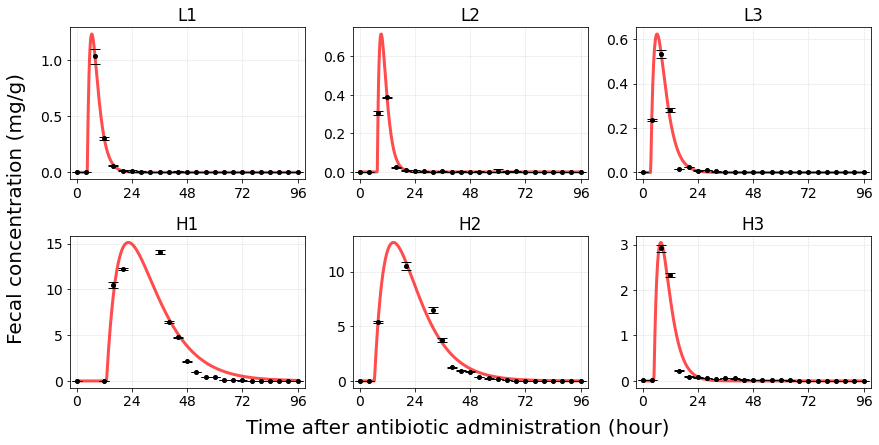

In [80]:
# Store RMSE values for each sample
rmse_list = []
all_y_true = []
all_y_pred = []

# Plotting results
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for n, ax in enumerate(axes.flatten()):
    df = pd.read_csv(f'VCM_{sample_list[n]}.csv', header=0, index_col=0)
    para_df = pd.read_csv(f'model2_{sample_list[n]}.csv', header=0, index_col=0)
    time = np.array(df.columns, dtype=float)
    data = np.array(df)
    avg = data.mean(axis=0)
    std = data.std(axis=0)
    
    # Dose level
    q = 0.5 if n < 3 else 10  # Low-dose for first 3 samples, high-dose for the rest
    
    # Use data up to 4 days after administration
    mask = time <= 96
    t, y = time[mask], avg[mask]
    
    params = para_df.iloc[0,:]
    
    # Plot fitting results
    t_fit = np.linspace(min(t), max(t), 500)
    y_fit = model2(params, t_fit, q)
    y_pred = model2(params, t, q)
    
    ax.plot(t_fit, y_fit, color="red", lw=3, alpha=0.7)
    ax.errorbar(t, y, yerr=std[mask], marker='o', markersize=4, color='black', capthick=1, capsize=5, lw=0)
    ax.set_title(f"{sample_list[n]}")
    ax.set_xlim(-3, 99)
    ax.set_xticks(np.arange(0, 97, 24))
    # Compute RMSE for this sample
    rmse = mean_squared_error(y, y_pred, squared=False)
    rmse_list.append(rmse)
    
    # Store values for overall RMSE computation
    all_y_true.extend(y)
    all_y_pred.extend(y_pred)
    
    print(f"Mouse {sample_list[n]} RMSE: {rmse:.4f}")

# Compute overall RMSE
overall_rmse = mean_squared_error(all_y_true, all_y_pred, squared=False)
print(f"Overall RMSE: {overall_rmse:.4f}")
    
# Labels and layout
fig.text(0.5, -0.01, 'Time after antibiotic administration (hour)', ha='center', va='center', fontsize=20)
fig.text(-0.01, 0.5, 'Fecal concentration (mg/g)', ha='center', va='center', rotation='vertical', fontsize=20)
fig.tight_layout()
plt.show()


## Plotting a Confidence Interval

In [44]:
def compute_avg_std(t_set, rep_list, time_list):
    """Compute the average and standard deviation for each time point."""
    avg_values, std_values = [], []
    for t in t_set:
        conct = []
        for n in range(len(rep_list)):
            conc, time = rep_list[n], time_list[n]
            if t in time:
                conct.extend(conc[:, list(time).index(t)])
        avg_values.append(np.mean(conct))
        std_values.append(np.std(conct))
    return avg_values, std_values

# Initialize lists to store data
t_all_list, y_all_list, rep_list = [], [], []

# Load data from CSV files
for n in range(6):
    df = pd.read_csv(f'VCM_{sample_list[n]}.csv', header=0, index_col=0)
    data = np.array(df)
    time = np.array(df.columns, dtype=float)
    avg = data.mean(axis=0)

    # Use data up to 4 days after administration (96 hours)
    mask = time <= 96
    t, y, y_rep = time[mask], avg[mask], data[:, mask]

    t_all_list.append(t)
    y_all_list.append(y)
    rep_list.append(y_rep)

# Separate data into low-dose and high-dose groups
low_t_all, low_y_all = np.concatenate(t_all_list[:3]), np.concatenate(y_all_list[:3])
low_rep_list = rep_list[:3]
high_t_all, high_y_all = np.concatenate(t_all_list[3:]), np.concatenate(y_all_list[3:])
high_rep_list = rep_list[3:]

# Compute unique time points
low_t, high_t = sorted(set(low_t_all)), sorted(set(high_t_all))

# Compute averages and standard deviations
low_avg, low_std = compute_avg_std(low_t, low_rep_list, t_all_list[:3])
high_avg, high_std = compute_avg_std(high_t, high_rep_list, t_all_list[3:])


### Model1

In [ ]:
# Set seed for reproducibility
seed = 0
np.random.seed(seed)

# Parameters
n_samples = 100
rate = 0.8
sample_size = int(len(low_t_all) * rate)
q = 0.5
l = 0.9
init = [1, 1, 1, 1]

# Lists to store results
resampling_samples = []
param_list = []

i = 0
while len(param_list) < n_samples:
    # Randomly sample time points without replacement
    indices = sorted(np.random.choice(len(low_t_all), size=sample_size, replace=False))
    resampling_samples.append((low_t_all[indices], low_y_all[indices]))
    
    # Optimize model parameters
    res = basinhopping(
        model1_loss, x0=init, stepsize=0.05,
        minimizer_kwargs={"method": 'Nelder-Mead', "args": (low_t_all[indices], low_y_all[indices], q, l)},
        niter=1000, niter_success=100, seed=0
    )
    
    # Store valid results
    if np.any(res.x != np.array(init)) and np.all(res.x > 0):
        t_tot, alpha, k_e, A = res.x
        t_in = q / alpha
        param_list.append([t_tot, t_in, k_e, A])
        i += 1

# Save results to CSV
pd.DataFrame(param_list, columns=['t_tot', 't_in', 'k_e', 'A']).to_csv(f'low_model1_resampling_rate{rate}_{n_samples}samples.csv', index=False)

In [ ]:
# Set seed for reproducibility
seed = 0
np.random.seed(seed)

# Parameters
n_samples = 100
rate = 0.8
sample_size = int(len(high_t_all) * rate)
q = 10
l = 0.9
init = [1, 1, 1, 1]

# Lists to store results
resampling_samples = []
param_list = []

i = 0
while len(param_list) < n_samples:
    # Randomly sample time points without replacement
    indices = sorted(np.random.choice(len(high_t_all), size=sample_size, replace=False))
    resampling_samples.append((high_t_all[indices], high_y_all[indices]))
    
    # Optimize model parameters
    res = basinhopping(
        model1_loss, x0=init, stepsize=0.05,
        minimizer_kwargs={"method": 'Nelder-Mead', "args": (high_t_all[indices], high_y_all[indices], q, l)},
        niter=1000, niter_success=100, seed=0
    )
    
    # Store valid results
    if np.any(res.x != np.array(init)) and np.all(res.x > 0):
        t_tot, alpha, k_e, A = res.x
        t_in = q / alpha
        param_list.append([t_tot, t_in, k_e, A])
        i += 1

# Save results to CSV
pd.DataFrame(param_list, columns=['t_tot', 't_in', 'k_e', 'A']).to_csv(f'high_model1_resampling_rate{rate}_{n_samples}samples.csv', index=False)

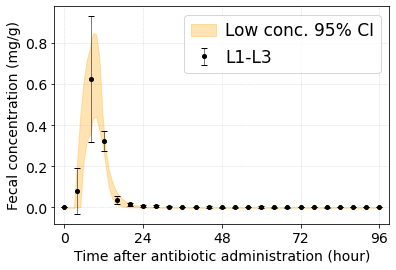

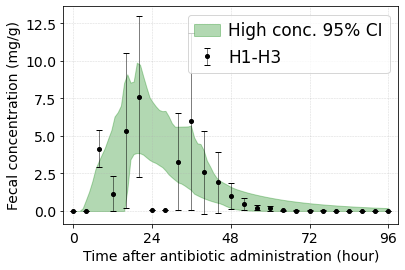

In [62]:
# Low-dose group
q = 0.5
param_list = np.array(pd.read_csv(f'low_model1_resampling_rate{rate}_{n_samples}samples.csv', header=0, index_col=0))
t_pred = np.linspace(0, max(low_t_all), 100)
y_samples = np.array([model1([t_tot, q/alpha, k_e, A], t_pred, q) for [t_tot, alpha, k_e, A] in param_list])
y_lower = np.percentile(y_samples, 2.5, axis=0)  # 2.5% パーセンタイル
y_upper = np.percentile(y_samples, 97.5, axis=0)  # 97.5% パーセンタイル

plt.fill_between(t_pred, y_lower, y_upper, color="orange", alpha=0.3,label='Low conc. 95% CI')
plt.errorbar(low_t, low_avg, yerr=low_std, fmt='o', ms=4, label='L1-L3', capsize=3, color='black',lw=0.5)
plt.xlabel('Time after antibiotic administration (hour)')
plt.ylabel("Fecal concentration (mg/g)")
plt.legend(bbox_to_anchor=(1,1),loc='upper right',fontsize=17, frameon=True,handlelength=1.5,handletextpad=0.5)
plt.xlim(-3,99)
plt.xticks(np.arange(0,97,24),np.arange(0,97,24))
plt.show()

# High-dose group
q = 10
param_list = np.array(pd.read_csv(f'high_model1_resampling_rate{rate}_{n_samples}samples.csv', header=0, index_col=0))
t_pred = np.linspace(0, max(high_t_all), 100)
y_samples = np.array([model1([t_tot, q/alpha, k_e, A], t_pred, q) for [t_tot, alpha, k_e, A] in param_list])
y_lower = np.percentile(y_samples, 2.5, axis=0)  # 2.5% パーセンタイル
y_upper = np.percentile(y_samples, 97.5, axis=0)  # 97.5% パーセンタイル

plt.fill_between(t_pred, y_lower, y_upper, color="green", alpha=0.3,label='High conc. 95% CI')
plt.errorbar(high_t, high_avg, yerr=high_std, fmt='o', ms=4, label='H1-H3', capsize=3, color='black',lw=0.5)
plt.xlabel('Time after antibiotic administration (hour)')
plt.ylabel("Fecal concentration (mg/g)")
plt.legend(bbox_to_anchor=(1,1),loc='upper right',fontsize=17, frameon=True,handlelength=1.5,handletextpad=0.5)
plt.xlim(-3,99)
plt.xticks(np.arange(0,97,24),np.arange(0,97,24))
plt.show()

### Model2

In [54]:
# Set seed for reproducibility
seed = 0
np.random.seed(seed)

# Parameters
n_samples = 100
rate = 0.8
sample_size = int(len(low_t_all) * rate)
q = 0.5
l = 0.9
init = [1, 1, 1, 1]

# Lists to store results
resampling_samples = []
param_list = []

i = 0
while len(param_list) < n_samples:
    # Randomly sample time points without replacement
    indices = sorted(np.random.choice(len(low_t_all), size=sample_size, replace=False))
    resampling_samples.append((low_t_all[indices], low_y_all[indices]))
    
    # Optimize model parameters
    res = basinhopping(
        model1_loss, x0=init, stepsize=0.05,
        minimizer_kwargs={"method": 'Nelder-Mead', "args": (low_t_all[indices], low_y_all[indices], q, l)},
        niter=1000, niter_success=100, seed=0
    )
    
    # Store valid results
    if np.any(res.x != np.array(init)) and np.all(res.x > 0):
        t_tot, k_a, k_e, A = res.x
        param_list.append([t_tot, k_a, k_e, A])
        i += 1

# Save results to CSV
pd.DataFrame(param_list, columns=['t_tot', 'k_a', 'k_e', 'A']).to_csv(f'low_model2_resampling_rate{rate}_{n_samples}samples.csv', index=False)

In [55]:
# Set seed for reproducibility
seed = 0
np.random.seed(seed)

# Parameters
n_samples = 100
rate = 0.8
sample_size = int(len(high_t_all) * rate)
q = 10
l = 0.9
init = [1, 1, 1, 1]

# Lists to store results
resampling_samples = []
param_list = []

i = 0
while len(param_list) < n_samples:
    # Randomly sample time points without replacement
    indices = sorted(np.random.choice(len(high_t_all), size=sample_size, replace=False))
    resampling_samples.append((high_t_all[indices], high_y_all[indices]))
    
    # Optimize model parameters
    res = basinhopping(
        model1_loss, x0=init, stepsize=0.05,
        minimizer_kwargs={"method": 'Nelder-Mead', "args": (high_t_all[indices], high_y_all[indices], q, l)},
        niter=1000, niter_success=100, seed=0
    )
    
    # Store valid results
    if np.any(res.x != np.array(init)) and np.all(res.x > 0):
        t_tot, k_a, k_e, A = res.x
        param_list.append([t_tot, k_a, k_e, A])
        i += 1

# Save results to CSV
pd.DataFrame(param_list, columns=['t_tot', 'k_a', 'k_e', 'A']).to_csv(f'high_model2_resampling_rate{rate}_{n_samples}samples.csv', index=False)

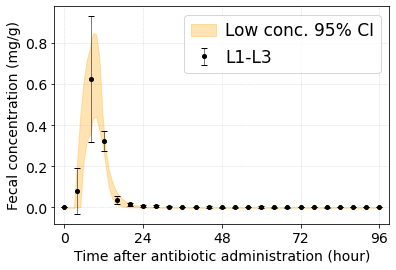

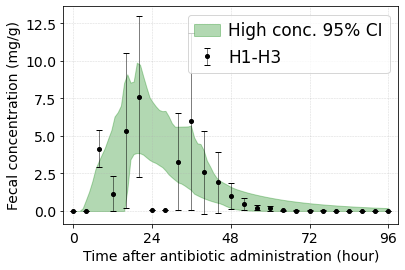

In [63]:
# Low-dose group
q = 0.5
param_list = np.array(pd.read_csv(f'low_model1_resampling_rate{rate}_{n_samples}samples.csv', header=0, index_col=0))
t_pred = np.linspace(0, max(low_t_all), 100)
y_samples = np.array([model1([t_tot, q/alpha, k_e, A], t_pred, q) for [t_tot, alpha, k_e, A] in param_list])
y_lower = np.percentile(y_samples, 2.5, axis=0)  # 2.5% パーセンタイル
y_upper = np.percentile(y_samples, 97.5, axis=0)  # 97.5% パーセンタイル

plt.fill_between(t_pred, y_lower, y_upper, color="orange", alpha=0.3,label='Low conc. 95% CI')
plt.errorbar(low_t, low_avg, yerr=low_std, fmt='o', ms=4, label='L1-L3', capsize=3, color='black',lw=0.5)
plt.xlabel('Time after antibiotic administration (hour)')
plt.ylabel("Fecal concentration (mg/g)")
plt.legend(bbox_to_anchor=(1,1),loc='upper right',fontsize=17, frameon=True,handlelength=1.5,handletextpad=0.5)
plt.xlim(-3,99)
plt.xticks(np.arange(0,97,24),np.arange(0,97,24))
plt.show()

# High-dose group
q = 10
param_list = np.array(pd.read_csv(f'high_model1_resampling_rate{rate}_{n_samples}samples.csv', header=0, index_col=0))
t_pred = np.linspace(0, max(high_t_all), 100)
y_samples = np.array([model1([t_tot, q/alpha, k_e, A], t_pred, q) for [t_tot, alpha, k_e, A] in param_list])
y_lower = np.percentile(y_samples, 2.5, axis=0)  # 2.5% パーセンタイル
y_upper = np.percentile(y_samples, 97.5, axis=0)  # 97.5% パーセンタイル

plt.fill_between(t_pred, y_lower, y_upper, color="green", alpha=0.3,label='High conc. 95% CI')
plt.errorbar(high_t, high_avg, yerr=high_std, fmt='o', ms=4, label='H1-H3', capsize=3, color='black',lw=0.5)
plt.xlabel('Time after antibiotic administration (hour)')
plt.ylabel("Fecal concentration (mg/g)")
plt.legend(bbox_to_anchor=(1,1),loc='upper right',fontsize=17, frameon=True,handlelength=1.5,handletextpad=0.5)
plt.xlim(-3,99)
plt.xticks(np.arange(0,97,24),np.arange(0,97,24))
plt.show()